<a href="https://colab.research.google.com/github/calibretaliation/DeepLearning20211/blob/main/siamese_net_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Shopee matching problem using Siamese-inspired approach

## Import

In [2]:
!git clone https://github.com/calibretaliation/DeepLearning20211.git

Cloning into 'DeepLearning20211'...
remote: Enumerating objects: 32799, done.
remote: Counting objects: 100% (333/333), done.
remote: Compressing objects: 100% (333/333), done.
remote: Total 32799 (delta 195), reused 0 (delta 0), pack-reused 32466
Receiving objects: 100% (32799/32799), 1.69 GiB | 31.16 MiB/s, done.
Resolving deltas: 100% (253/253), done.
Checking out files: 100% (32430/32430), done.


In [3]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [4]:
#@title Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
import math
import random

import os
import pickle

import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications, layers, losses, optimizers, metrics, Model, callbacks
from tensorflow.keras.applications import resnet, mobilenet_v3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from keras import backend

import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import top_k_accuracy_score
import seaborn as sns

from pathlib import Path

# import tensorflow_docs as tfdocs
# import tensorflow_docs.modeling
# import tensorflow_docs.plots


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

## Load and preprocess datasets

In [5]:
#@title Load CSV

train_df = pd.read_csv('DeepLearning20211/data/train.csv')
train_img_dir = Path('DeepLearning20211/data/train_images')

In [6]:
# train_df = pd.concat([train_df.iloc[:100], train_df.iloc[:100]]).reset_index(drop=True)

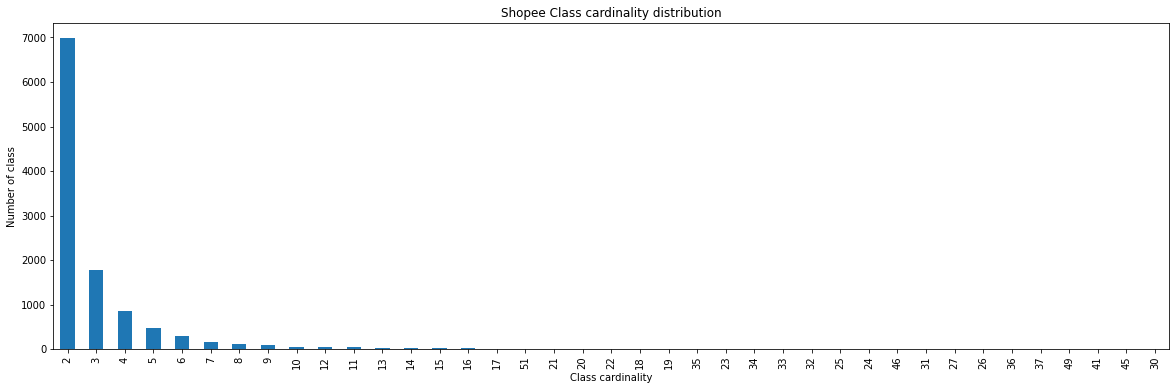

In [7]:
#@title Plot class cardinality distribution

# calculate number of images in each class
label_count = train_df['label_group'].value_counts()

plt.figure(figsize=(20, 6))
label_count.value_counts().plot.bar()
plt.xlabel('Class cardinality')
plt.ylabel('Number of class')
plt.title('Shopee Class cardinality distribution')
plt.show()

In [8]:
#@title Create validation set

train_df['index'] = train_df.index
val_df = train_df.sample(frac=1, random_state=14).groupby('label_group').nth(0)
val_df['label_group'] = val_df.index
val_df = val_df.set_index('index')
train_df = train_df.drop('index', axis=1)
train_df = train_df.drop(index=val_df.index).reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [9]:
# import shutil
# shutil.rmtree(str(temp_dir), ignore_errors=True)

In [10]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label_group'])

LabelEncoder()

In [11]:
batch_size = 64

data_augmentation = tf.keras.Sequential(
    [
     layers.RandomRotation(0.5),
     layers.RandomContrast(0.5),
     layers.RandomZoom((-0.2, 0.2)),
     layers.RandomTranslation(0.14, 0.14),
     ]
)

def filepath_to_img(filepath):
    img_string = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img_string)

    return img

def configure_dataset(ds, mode, batch_size, fine_tune=False):
    assert mode == 'training' or mode == 'validation', "mode should be 'training' or 'validation'" 
    
    ds = ds.map(lambda filepath, label: (filepath_to_img(filepath), label), 
                num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.map(lambda img, label: (layers.Resizing(224, 224, crop_to_aspect_ratio=True)(img), label),
                num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.map(lambda img, label: (data_augmentation(img), label), 
                num_parallel_calls=tf.data.AUTOTUNE)
    
    if not fine_tune:               # we'll use some available preprocessing in keras model
        ds = ds.map(lambda img, label: (layers.Rescaling(1./255, offset=-1)(img), label),
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.prefetch(buffer_size=2048)
    ds = ds.batch(batch_size)
    
    return ds

## Define model and utilities

In [12]:
#@title Define embedding model (Run only once)

def get_embedding_model(first_trainable_layer=200):
    base_model = applications.MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3), include_top=False, include_preprocessing=True)

    output = layers.Flatten()(base_model.output)
    output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output)

    embedding = Model(base_model.input, output, name='Embedding')

    trainable = False
    for i in range(len(base_model.layers)):
        if i == first_trainable_layer:
            trainable = True
        base_model.layers[i].trainable = trainable

    return embedding

In [13]:
#@title Define custom callback

def get_summary_writer(name):
    log_dir = 'logs/' + name
    return {
        'train': tf.summary.create_file_writer(log_dir + '/train'),
        'val': tf.summary.create_file_writer(log_dir + '/val'),
        'lr': tf.summary.create_file_writer(log_dir + '/lr'),
        'best_weights': None,
        'epoch_loss' : [],
        'epoch_val_loss': []

    }

image_summary_writer = tf.summary.create_file_writer('logs/images')

class MyCallback(callbacks.Callback):
    def __init__(self, writers, reduce_lr=True, restore_best_weights=True):
        super(MyCallback, self).__init__()

        self.reduce_lr = reduce_lr
        self.restore_best_weights = restore_best_weights
        self.writers = writers

    def on_epoch_end(self, epoch, logs={}):

        with self.writers['lr'].as_default():
            tf.summary.scalar('learning rate', backend.get_value(self.model.optimizer.lr), step=len(self.writers['epoch_val_loss']))

        if self.reduce_lr and len(self.writers['epoch_loss']) > 0 and logs.get('loss') > self.writers['epoch_loss'][-1]:
            new_lr = backend.get_value(self.model.optimizer.lr) / 10.0
            backend.set_value(self.model.optimizer.lr, new_lr)
            print("\n[MyCallback]: Learning rate reduced to {}.".format(new_lr))

        if self.restore_best_weights and (len(self.writers['epoch_val_loss']) == 0 or logs.get('val_loss') < min(self.writers['epoch_val_loss']) - 1e-4):
            self.writers['best_weights'] = self.model.get_weights()
            print("\n[MyCallback]: Best weights on val_loss saved to 'best_weight'.")

        self.writers['epoch_loss'].append(logs.get('loss'))
        self.writers['epoch_val_loss'].append(logs.get('val_loss'))

        with self.writers['train'].as_default():
            tf.summary.scalar('loss', logs.get('loss'), step=len(self.writers['epoch_loss']) - 1)
        
        with self.writers['val'].as_default():
            tf.summary.scalar('loss', logs.get('val_loss'), step=len(self.writers['epoch_val_loss']) - 1)

In [14]:
def get_train_ds(train_df, batch_size):
    train_df = train_df.sample(frac=1.0).reset_index(drop=True)
    train_ds = pd.concat([train_df, train_df]).sort_index(axis=0)
    train_ds = tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep + train_ds['image'], label_encoder.transform(train_ds['label_group'])))
    train_ds = configure_dataset(train_ds, mode='training', batch_size=batch_size, fine_tune=True)     # training using keras pretrained-model

    return train_ds

In [15]:
val_ds = pd.concat([val_df, val_df]).sort_index(axis=0)
val_labels = label_encoder.transform(val_ds['label_group'])
val_ds_raw = tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep + val_ds['image'], val_labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


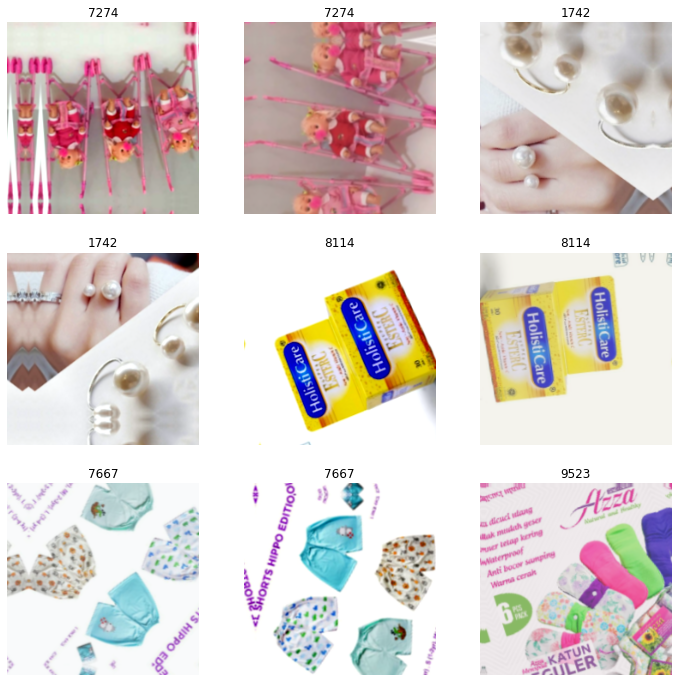

In [16]:
#@title Plot some training images
ncols = 3
nrows = 3
plt.figure(figsize=(4*ncols, 4*nrows))
spec = gridspec.GridSpec(ncols=ncols, nrows=nrows)
for img_batch, label_batch in get_train_ds(train_df, batch_size=9).take(1):
    with image_summary_writer.as_default():
            tf.summary.image('training image', img_batch/255, max_outputs=64, step=0)
    i = 0
    for img, label in zip(img_batch, label_batch):
        plt.subplot(spec[i])
        plt.imshow(img/255)
        plt.title(label.numpy())
        plt.axis('off')

        i += 1
        if i == nrows * ncols:
            break
plt.show()

In [17]:
def train(embedding, batch_size, num_epoch, writers):

    val_ds = configure_dataset(val_ds_raw, mode='validation', batch_size=batch_size, fine_tune=True)   # evaluation using keras pretrained-model

    max_epoch = num_epoch + len(writers['epoch_loss'])
    for _ in range(num_epoch):
        train_ds = get_train_ds(train_df, batch_size)

        print('Epoch %d/%d' % (len(writers['epoch_loss']) + 1, max_epoch))

        embedding.fit(
            train_ds,
            epochs=1,
            validation_data=val_ds,
            callbacks=[MyCallback(writers, reduce_lr=True, restore_best_weights=True)]
        )

## Train and evaluate model

In [21]:
batch_size = 64

exec('embedding_{} = get_embedding_model()'.format(batch_size))
exec("summary_writers_{0} = get_summary_writer('{0}')".format(batch_size))
print('Training embedding_{0}, logs saving in summary_writers_{0}'.format(batch_size))

exec("""embedding_{}.compile(
    optimizer=SGD(learning_rate=8e-3, momentum=0.9, nesterov=True),
    loss=tfa.losses.TripletSemiHardLoss(),
    )""".format(batch_size))

train(eval('embedding_{}'.format(batch_size)), batch_size=batch_size, num_epoch=8, writers=eval("summary_writers_{0}".format(batch_size)))

Epoch 1/8
727/727 [==============================] - ETA: 0s - loss: 0.1072
[MyCallback]: Best weights on val_loss saved to 'best_weight'.
727/727 [==============================] - 1092s 1s/step - loss: 0.1072 - val_loss: 0.1278
Epoch 2/8
727/727 [==============================] - ETA: 0s - loss: 0.1102
[MyCallback]: Learning rate reduced to 8.000000525498762e-06.
727/727 [==============================] - 1113s 2s/step - loss: 0.1102 - val_loss: 0.1282
Epoch 3/8
727/727 [==============================] - ETA: 0s - loss: 0.1080
[MyCallback]: Best weights on val_loss saved to 'best_weight'.
727/727 [==============================] - 1068s 1s/step - loss: 0.1080 - val_loss: 0.1263
Epoch 4/8
727/727 [==============================] - 1057s 1s/step - loss: 0.1075 - val_loss: 0.1285
Epoch 5/8
727/727 [==============================] - ETA: 0s - loss: 0.1104
[MyCallback]: Learning rate reduced to 8.000000889296644e-07.
727/727 [==============================] - 1056s 1s/step - loss: 0.1104 

In [ ]:
batch_size = 128

exec('embedding_{} = get_embedding_model()'.format(batch_size))
exec("summary_writers_{0} = get_summary_writer('{0}')".format(batch_size))
print('Training embedding_{0}, logs saving in summary_writers_{0}'.format(batch_size))

exec("""embedding_{}.compile(
    optimizer=SGD(learning_rate=8e-3, momentum=0.9, nesterov=True),
    loss=tfa.losses.TripletSemiHardLoss(),
    )""".format(batch_size))

train(eval('embedding_{}'.format(batch_size)), batch_size=batch_size, num_epoch=8, writers=eval("summary_writers_{0}".format(batch_size)))

In [ ]:
embedding = embedding_128

In [ ]:
#@title Create anchor embeddings

%%time

set_seed(42)
anchor_df = train_df.groupby('label_group').nth(0)

anchor_df['label_group'] = anchor_df.index
anchor_df = anchor_df.reset_index(drop=True)

num_per_anchor = 4

anchor_df = pd.concat([anchor_df for _ in range(num_per_anchor)]).sort_index(axis=0)
anchor_labels = label_encoder.transform(anchor_df['label_group'])
anchor_ds = tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep + anchor_df['image'], anchor_labels))
anchor_ds = configure_dataset(anchor_ds, mode='training', batch_size=64, fine_tune=True)
anchor_embeddings = embedding.predict(anchor_ds)

pca = PCA(n_components=2)
decomposed_embeddings = pca.fit_transform(anchor_embeddings)

print('Anchor embeddings created')

In [ ]:
#@title Use KNN for classification task

%%time
KNN = KNeighborsClassifier(n_neighbors=num_per_anchor)
KNN.fit(anchor_embeddings, anchor_labels)

In [ ]:
#@title Calculate embeddings for validation set

%%time
val_ds = configure_dataset(val_ds_raw, mode='validation', batch_size=64, fine_tune=True)   # evaluation using keras pretrained-model
val_embeddings = embedding.predict(val_ds)

In [ ]:
with open('/content/drive/MyDrive/checkpoint/anchor_embeddings.pkl', 'wb') as f:
    pickle.dump(anchor_embeddings, f)

with open('/content/drive/MyDrive/checkpoint/anchor_labels.pkl', 'wb') as f:
    pickle.dump(anchor_labels, f)

with open('/content/drive/MyDrive/checkpoint/val_embeddings.pkl', 'wb') as f:
    pickle.dump(val_embeddings, f)

with open('/content/drive/MyDrive/checkpoint/val_labels.pkl', 'wb') as f:
    pickle.dump(val_labels, f)

In [ ]:
#@title Predict class probabilities for each validation image

%%time

val_preds = KNN.predict_proba(val_embeddings)

In [ ]:
#@title Top-K accuracy

k =  1#@param {type: "integer"}

top_k_accuracy_score(val_labels, val_preds, k=k)

In [ ]:
#@title Visualize anchor embeddings on 2D plane

num_class = 30 #@param {type: 'integer'}
plt.figure(figsize=(10, 10))
sns.scatterplot(x=decomposed_embeddings[:num_per_anchor * num_class, 0], 
                y=decomposed_embeddings[:num_per_anchor * num_class, 1], 
                hue=anchor_labels[:num_per_anchor * num_class], 
                palette=cm.get_cmap('Spectral')
)

In [ ]:
embedding_64.save('/content/drive/MyDrive/checkpoint/embedding_64')

In [ ]:
!zip -r logs_64_3.zip logs

In [19]:
embedding_64 = tf.keras.models.load_model('/content/drive/MyDrive/checkpoint/embedding_64')

In [ ]:
max_epoch = len(epoch_loss_histories['loss'])
plt.plot(range(max_epoch), epoch_loss_histories['loss'], label='loss')
plt.plot(range(max_epoch), epoch_loss_histories['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [22]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

# Testing

In [ ]:
from tensorboard.plugins import projector



# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir='/logs/imdb-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for subwords in encoder.subwords:
    f.write("{}\n".format(subwords))
  # Fill in the rest of the labels with "unknown".
  for unknown in range(1, encoder.vocab_size - len(encoder.subwords)):
    f.write("unknown #{}\n".format(unknown))


# Save the weights we want to analyze as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, here
# we will remove this value.
weights = tf.Variable(model.layers[0].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
https://www.tensorflow.org/tensorboard/tensorboard_profiling_keras